# Metabolomics Data Analysis

This notebook is designed for processing metabolomics data obtained through FT-ICR-MS. It assumes that a series of mass spectra were obtained and converted into lists of compounds. The software performs spectral alignment, annotation and basic data exploration and statistical analysis.

Before you begin, make sure to verify you have all the necessary imports by running the cell immediately after this text. In case you find any library missing, you can install it by simply opening your command line and typing 'pip install [name of the library]'

In [2]:
import pandas as pd
import numpy as np


import re

from tqdm import tqdm

import itertools

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import sklearn.ensemble as skensemble
from sklearn.metrics import (roc_auc_score, roc_curve, auc,
                             f1_score, precision_score, recall_score)
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import TwoSlopeNorm

import seaborn as sns
import pickle

# Our Python package
import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks import align, read_data_from_xcel

# elips.py file (has to be in the same folder)
from elips import plot_confidence_ellipse
# venn.py file
import venn as venn
import mda as mda

SyntaxError: invalid syntax (Temp/ipykernel_36256/1805543381.py, line 3)

# Step 1: Align your mass spectra

This notebook assumes you start with an excel file containing, in a single sheet, the lists of detected masses and respective intensities for each mass spectrum. The name of the sample muust be provided in a header in row 1, while row 2 must identify m/z and intensity columns. There must be an empy column between every two different samples.

![text](data_format.png)

First, we will read your file

In [54]:
filename = 'PEXII 23_24.xlsx'

read_file = read_data_from_xcel(filename,  header=[0, 1], drop_header_levels=1)

read_file

OrderedDict([('Sheet1',
              [                  THP1_1
               (THP1_1, m/z)           
               101.38100      1032093.0
               101.41474       717191.0
               101.72093       625493.0
               101.74934      1221514.0
               103.04555      1104827.0
               ...                  ...
               922.48271      2833048.0
               951.85621      1979103.0
               970.48418      3034528.0
               971.48733      2395518.0
               982.34533      2141450.0
               
               [2450 rows x 1 columns],
                                 THP1_2
               (THP1_2, m/z)           
               101.07656       643706.0
               101.41474       703120.0
               101.74935      1447226.0
               102.37367       640559.0
               102.38578       718638.0
               ...                  ...
               909.65162      3636954.0
               910.65446      2199253.0


As you can see, it identifies all the different compound lists...

In [55]:
frames = list(read_file.values())[0]
frames

[                  THP1_1
 (THP1_1, m/z)           
 101.38100      1032093.0
 101.41474       717191.0
 101.72093       625493.0
 101.74934      1221514.0
 103.04555      1104827.0
 ...                  ...
 922.48271      2833048.0
 951.85621      1979103.0
 970.48418      3034528.0
 971.48733      2395518.0
 982.34533      2141450.0
 
 [2450 rows x 1 columns],
                   THP1_2
 (THP1_2, m/z)           
 101.07656       643706.0
 101.41474       703120.0
 101.74935      1447226.0
 102.37367       640559.0
 102.38578       718638.0
 ...                  ...
 909.65162      3636954.0
 910.65446      2199253.0
 921.47924      6258046.0
 922.48268      2972998.0
 970.48425      2309995.0
 
 [2479 rows x 1 columns],
                   THP1_3
 (THP1_3, m/z)           
 101.35235      1828876.0
 101.37146      5653068.0
 101.41474       657228.0
 101.74935      1319215.0
 102.83569       629647.0
 ...                  ...
 868.37770      7228087.0
 869.38092      2552640.0
 909.651

After choosing a PPM tolerance and filtering out likely experimental artifacts (if a mass value only appears once across all sample, it is likely thtat it's not a real compound present in the sample,) we produce an aligned spectra dataframe.

In [56]:
ppmtol = 1.0 # PPM Tolerance
min_samples = 2 # Number of times a compound needs to appear across all samples to be included

aligned_spectra = align(frames, ppmtol, min_samples)

aligned_spectra

------ Aligning tables -------------
 Samples to align: [['THP1_1'], ['THP1_2'], ['THP1_3'], ['THP1_4'], ['THP1_5'], ['THP1_6'], ['THP1_7'], ['Ecoli_1'], ['Ecoli_2'], ['Ecoli_3'], ['Ecoli_4'], ['Ecoli_5'], ['Ecoli_6'], ['Ecoli_7']]
- Extracting all features...
  Done, (total 35972 features in 14 samples)
- Grouping and joining...
  Done, 5228 groups found
Elapsed time: 00m 09.384s

- 1349 groups were discarded (#samples < 2)
Sample coverage of features
  541 features in 2 samples
  287 features in 3 samples
  213 features in 4 samples
  158 features in 5 samples
  146 features in 6 samples
  413 features in 7 samples
  143 features in 8 samples
  109 features in 9 samples
  101 features in 10 samples
   94 features in 11 samples
  106 features in 12 samples
  122 features in 13 samples
 1446 features in 14 samples
m/z range (ppm) distribution
  [0.0,0.1[ : 498
  [0.1,0.2[ : 1425
  [0.2,0.3[ : 809
  [0.3,0.4[ : 404
  [0.4,0.5[ : 224
  [0.5,0.6[ : 146
  [0.6,0.7[ : 99
  [0.7,0.8[ : 71
  

,THP1_1,THP1_2,THP1_3,THP1_4,THP1_5,THP1_6,THP1_7,Ecoli_1,Ecoli_2,Ecoli_3,Ecoli_4,Ecoli_5,Ecoli_6,Ecoli_7
101.390555,NaN,NaN,NaN,NaN,1111150.0,NaN,NaN,1058128.0,NaN,NaN,NaN,NaN,NaN,NaN
101.414740,717191.0,703120.0,657228.0,1034138.0,909934.0,854585.0,NaN,1402898.0,1404687.0,1248817.0,1299641.0,1111691.0,1168892.0,1151265.0
101.749350,1221514.0,1447226.0,1319215.0,1240094.0,1303320.0,1454590.0,1324925.0,832418.0,NaN,NaN,NaN,NaN,NaN,NaN
102.084760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,665758.0,731418.0,654863.0,NaN,NaN,NaN,NaN
102.373670,NaN,640559.0,NaN,NaN,NaN,NaN,NaN,706394.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970.484425,3034528.0,2309995.0,NaN,NaN,NaN,NaN,2012906.0,2423117.0,2496550.0,2183521.0,NaN,NaN,NaN,NaN
971.486980,2395518.0,NaN,NaN,NaN,NaN,NaN,NaN,2021708.0,NaN,NaN,NaN,NaN,NaN,NaN
980.348250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2193736.0,2840556.0,2322811.0,2008377.0,NaN,NaN,NaN
982.345395,2141450.0,NaN,NaN,NaN,NaN,NaN,NaN,2113864.0,2955246.0,2556282.0,NaN,NaN,NaN,NaN


# Step 2: Calculate Neutral masses and prepare data for analysis

Before we can start identifying the compounds in the spectra, we must first calculate their neutral masses. When the ionnization mode was positive (that is, the molecules were all converted into cations,) that is done by subtracting the proton mass.

In [57]:
bucket_table = aligned_spectra.reset_index().rename(columns = {'index': 'm/z'})
bucket_table

electron_mass = 0.000548579909065
h_mass = 1.007825031898
proton_mass = h_mass-electron_mass

bucket_table.insert(1, 'Neutral Mass', bucket_table['m/z']-proton_mass)
bucket_table['Bucket label'] = bucket_table['Neutral Mass'].astype('str')+' Da'
bucket_table = bucket_table.set_index('Bucket label')

bucket_table

,m/z,Neutral Mass,THP1_1,THP1_2,THP1_3,THP1_4,THP1_5,THP1_6,THP1_7,Ecoli_1,Ecoli_2,Ecoli_3,Ecoli_4,Ecoli_5,Ecoli_6,Ecoli_7
Bucket label,,,,,,,,,,,,,,,,
100.38327854801108 Da,101.390555,100.383279,NaN,NaN,NaN,NaN,1111150.0,NaN,NaN,1058128.0,NaN,NaN,NaN,NaN,NaN,NaN
100.40746354801107 Da,101.414740,100.407464,717191.0,703120.0,657228.0,1034138.0,909934.0,854585.0,NaN,1402898.0,1404687.0,1248817.0,1299641.0,1111691.0,1168892.0,1151265.0
100.74207354801108 Da,101.749350,100.742074,1221514.0,1447226.0,1319215.0,1240094.0,1303320.0,1454590.0,1324925.0,832418.0,NaN,NaN,NaN,NaN,NaN,NaN
101.07748354801107 Da,102.084760,101.077484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,665758.0,731418.0,654863.0,NaN,NaN,NaN,NaN
101.36639354801108 Da,102.373670,101.366394,NaN,640559.0,NaN,NaN,NaN,NaN,NaN,706394.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969.4771485480112 Da,970.484425,969.477149,3034528.0,2309995.0,NaN,NaN,NaN,NaN,2012906.0,2423117.0,2496550.0,2183521.0,NaN,NaN,NaN,NaN
970.4797035480111 Da,971.486980,970.479704,2395518.0,NaN,NaN,NaN,NaN,NaN,NaN,2021708.0,NaN,NaN,NaN,NaN,NaN,NaN
979.3409735480111 Da,980.348250,979.340974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2193736.0,2840556.0,2322811.0,2008377.0,NaN,NaN,NaN


In [58]:
# Identify sample columns
sample_cols = []
for c in bucket_table.columns:
    if c not in ['Neutral Mass', 'm/z']:
        sample_cols.append(c)
print(sample_cols)

['THP1_1', 'THP1_2', 'THP1_3', 'THP1_4', 'THP1_5', 'THP1_6', 'THP1_7', 'Ecoli_1', 'Ecoli_2', 'Ecoli_3', 'Ecoli_4', 'Ecoli_5', 'Ecoli_6', 'Ecoli_7']


We must also assign a group label to every sample, identifying exactly what they are. To do this, we create a list of group labels thst follows the same order as the sample columns in the bucket table

In [59]:
# Defining groups
target = ['THP1', 'THP1', 'THP1', 'THP1', 'THP1', 'THP1', 'THP1', 'Ecoli', 'Ecoli', 'Ecoli', 'Ecoli', 'Ecoli', 'Ecoli', 'Ecoli']

In [60]:
# See if the classes are those that you want
classes = list(pd.unique(target))
classes

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/1258312062.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  classes = list(pd.unique(target))


['THP1', 'Ecoli']

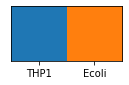

In [61]:
# customize label colors

colours = sns.color_palette('tab10', 10) # Only room for 10 classes in this case, choose your colours
#colours = ('coral', 'turquoise', 'gold', 'indigo', 'lightgreen') # Example for using named colours
ordered_labels = classes # Put the classes, you can choose the order

label_colours = {lbl: c for lbl, c in zip(ordered_labels, colours)}
sample_colours = [label_colours[lbl] for lbl in target]

# See the colours for each class
sns.palplot(label_colours.values())
new_ticks = plt.xticks(range(len(ordered_labels)), ordered_labels)

# Step 3: Annotate your data

To perform metabolites annotation, you must first obtain a database that is both comprehensive and specific to the type of samples you are analysing. 

For human samples, this may be the Human Metabolome Database (HMDB), which has over 200 000 entries! 

https://hmdb.ca/

In [62]:
dbs = { # How you want the database to be called in the data
    'HMDB': {'File': 'hmdb_complete.xlsx', # The name of each file
             'Index_name': 'accession', # The name of the index in each database
             'Name_col': 'name', # The name column in each database
             'Mass_col': 'monisotopic_molecular_weight', # The mass column in each database. Can be None
             'Formula_col': 'chemical_formula'}, # The formula column in each database
}

In [63]:
# testing it
for d in dbs:
    print(d, ' -> ', dbs[d]['File'], '|', dbs[d]['Index_name'],'|', dbs[d]['Mass_col'],'|', 
          dbs[d]['Name_col'],'|', dbs[d]['Formula_col'])

HMDB  ->  hmdb_complete.xlsx | accession | monisotopic_molecular_weight | name | chemical_formula


In [64]:
# Upload databases
for d in dbs:
    print('Processing '+d)
    if dbs[d]['File'].endswith('.csv'):
        db = pd.read_csv(dbs[d]['File']).set_index(dbs[d]['Index_name'])
        if d == 'HMDB':
            db['name'] = db['name'].str.replace("b'", "")
            db['name'] = db['name'].str.replace("'", "")
    elif dbs[d]['File'].endswith('.xlsx'):
        db = pd.read_excel(dbs[d]['File']).set_index(dbs[d]['Index_name'])
        if d == 'HMDB':
            db['name'] = db['name'].str.replace("b'", "")
            db['name'] = db['name'].str.replace("'", "")
    else:
        raise ValueError('File Format not accepted. Only csv and xlsx files are accepted.')
    ##
    if dbs[d]['Mass_col'] == None:
        db['Calculated Mass'] = db[dbs[d]['Formula_col']].dropna().apply(mda.calculate_monoisotopic_mass)
        dbs[d]['Mass_col'] = 'Calculated Mass'
    ##
    dbs[d]['DB'] = db
    print(d,'->', len(db.index), 'compounds')

Processing HMDB
HMDB -> 217920 compounds


Now, we define a PPM margin (maximum mass error allowed) and annotate the experimental data with the uploaded databases

In [65]:
ppm_margin = 1

# Annotation
annotated_data = bucket_table.copy()
    
annotated_data = mda.metabolite_annotation(annotated_data, dbs, ppm_margin)

Annotating with HMDB 

100%|█████████████████████████████████████████████████████████████████████████████| 3879/3879 [00:13<00:00, 285.38it/s]

-> Annotated 367 compounds
---------------


In [66]:
annotated_data

,m/z,Neutral Mass,THP1_1,THP1_2,THP1_3,THP1_4,THP1_5,THP1_6,THP1_7,Ecoli_1,Ecoli_2,Ecoli_3,Ecoli_4,Ecoli_5,Ecoli_6,Ecoli_7,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count
Bucket label,,,,,,,,,,,,,,,,,,,,
100.38327854801108 Da,101.390555,100.383279,NaN,NaN,NaN,NaN,1111150.0,NaN,NaN,1058128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100.40746354801107 Da,101.414740,100.407464,717191.0,703120.0,657228.0,1034138.0,909934.0,854585.0,NaN,1402898.0,1404687.0,1248817.0,1299641.0,1111691.0,1168892.0,1151265.0,NaN,NaN,NaN,NaN
100.74207354801108 Da,101.749350,100.742074,1221514.0,1447226.0,1319215.0,1240094.0,1303320.0,1454590.0,1324925.0,832418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101.07748354801107 Da,102.084760,101.077484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,665758.0,731418.0,654863.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101.36639354801108 Da,102.373670,101.366394,NaN,640559.0,NaN,NaN,NaN,NaN,NaN,706394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969.4771485480112 Da,970.484425,969.477149,3034528.0,2309995.0,NaN,NaN,NaN,NaN,2012906.0,2423117.0,2496550.0,2183521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
970.4797035480111 Da,971.486980,970.479704,2395518.0,NaN,NaN,NaN,NaN,NaN,NaN,2021708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979.3409735480111 Da,980.348250,979.340974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2193736.0,2840556.0,2322811.0,2008377.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
meta_cols = [i for i in annotated_data.columns if i not in sample_cols]
meta_cols_ids = [i for i in meta_cols if 'IDs' in i]
meta_cols_names = [i for i in meta_cols if 'names' in i]
meta_cols_formulas = [i for i in meta_cols if 'formulas' in i]
meta_cols_mcounts = [i for i in meta_cols if 'match count' in i]
print(meta_cols)
print('------------')
print(meta_cols_ids)
print('------------')
print(meta_cols_names)
print('------------')
print(meta_cols_formulas)
print('------------')
print(meta_cols_mcounts)

['m/z', 'Neutral Mass', 'Matched HMDB IDs', 'Matched HMDB names', 'Matched HMDB formulas', 'HMDB match count']
------------
['Matched HMDB IDs']
------------
['Matched HMDB names']
------------
['Matched HMDB formulas']
------------
['HMDB match count']


In [68]:
print('Checking all matches')
if len(dbs) == 0:
    if 'Name' in annotated_data.columns:
        for i in tqdm(annotated_data.index):
            df = annotated_data.loc[[i]]
            hasmatch = df['Name'].notnull().values.any()
            annotated_data.at[i, 'Has Match?'] = hasmatch
        print('Nº of Annotated Compounds:', annotated_data[annotated_data['Has Match?'] == True].sum())
    else:
        print('No Check Neccessary')
else:
    if 'Name' in annotated_data.columns:
        cols_to_see = ['Name'] + list(annotated_data.columns[-len(dbs)*4:])
    else:
        cols_to_see = list(annotated_data.columns[-len(dbs)*4:])
    annotated_data['Has Match?'] = np.nan
    for i in tqdm(annotated_data.index):
        df = annotated_data.loc[[i]]
        hasmatch = df[cols_to_see].notnull().values.any()
        annotated_data.at[i, 'Has Match?'] = hasmatch
    print('Nº of Annotated Compounds:', (annotated_data['Has Match?'] == True).sum())
    print('---------------')

annotated_data.info(verbose= True)
annotated_data   

Checking all matches


  0%|                                                                                         | 0/3879 [00:00<?, ?it/s]C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/4156928079.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annotated_data.at[i, 'Has Match?'] = hasmatch
100%|█████████████████████████████████████████████████████████████████████████████| 3879/3879 [00:05<00:00, 762.81it/s]

Nº of Annotated Compounds: 367
---------------
<class 'pandas.core.frame.DataFrame'>
Index: 3879 entries, 100.38327854801108 Da to 983.335278548011 Da
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   m/z                    3879 non-null   float64
 1   Neutral Mass           3879 non-null   float64
 2   THP1_1                 2364 non-null   float64
 3   THP1_2                 2398 non-null   float64
 4   THP1_3                 2286 non-null   float64
 5   THP1_4                 2307 non-null   float64
 6   THP1_5                 2315 non-null   float64
 7   THP1_6                 2287 non-null   float64
 8   THP1_7                 2356 non-null   float64
 9   Ecoli_1                2786 non-null   float64
 10  Ecoli_2                2748 non-null   float64
 11  Ecoli_3                2659 non-null   float64
 12  Ecoli_4                2572 non-null   float64
 13  Ecoli_5                2568 non

,m/z,Neutral Mass,THP1_1,THP1_2,THP1_3,THP1_4,THP1_5,THP1_6,THP1_7,Ecoli_1,...,Ecoli_3,Ecoli_4,Ecoli_5,Ecoli_6,Ecoli_7,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Has Match?
Bucket label,,,,,,,,,,,,,,,,,,,,,
100.38327854801108 Da,101.390555,100.383279,NaN,NaN,NaN,NaN,1111150.0,NaN,NaN,1058128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
100.40746354801107 Da,101.414740,100.407464,717191.0,703120.0,657228.0,1034138.0,909934.0,854585.0,NaN,1402898.0,...,1248817.0,1299641.0,1111691.0,1168892.0,1151265.0,NaN,NaN,NaN,NaN,False
100.74207354801108 Da,101.749350,100.742074,1221514.0,1447226.0,1319215.0,1240094.0,1303320.0,1454590.0,1324925.0,832418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
101.07748354801107 Da,102.084760,101.077484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,665758.0,...,654863.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
101.36639354801108 Da,102.373670,101.366394,NaN,640559.0,NaN,NaN,NaN,NaN,NaN,706394.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969.4771485480112 Da,970.484425,969.477149,3034528.0,2309995.0,NaN,NaN,NaN,NaN,2012906.0,2423117.0,...,2183521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
970.4797035480111 Da,971.486980,970.479704,2395518.0,NaN,NaN,NaN,NaN,NaN,NaN,2021708.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
979.3409735480111 Da,980.348250,979.340974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2193736.0,...,2322811.0,2008377.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


# Step 4: Treat your data for further analysis

While the 'raw' data are more than good enough for metabolite identification, metabolomics data analyses often requires information to be drawn from intensity values, as well as the use of statistical techniques. For these purposes, it's important that we apply at least a few of the most common data pre-treatments.

This section performs the following:

- **Filtering:** Sometimes, it can be useful to consider only metabolites that appear above a certain number of times across all samples (or accross samples of a certain class.) This is already done in the alignment step, so unless you want to further restrict your analysis, it should be redundant. However, it never hurts to have a check!
- **Missing value imputation:** Statistical analysis algorithms will not accept missing values in your data, so if a compound does not appear in a certain sample, it is necessary to 'fill' the bucket with a number. This could simply be 0, however, the presence of a 0 can be too agressive for statistical analysis, giving these compounds excessive influence over the results, so imputation is often done with a fraction of the minimum intensity of any compound in the sample.
- **Normalization:** To take any conclusions whatsoever from intensity values, these must be normalised. A common strategy is to normalize to a reference feature (usually the internal standard of the FT-ICR-MS analysis, or, alternatively, an extremely abundant metabolite across all samples,) but a more robust method may be to normalize to the sum of all intensities in the sample.
- **Scaling:** Scaling algorithms reduce the magnitude of the differences between more and less abundant metabolites, preventing the more abundant ones from completely overpowering the rest. The Pareto method is a type of scaling that is softer than most alternative, and thus is very commonly used in metabolomics because it strikes a balanced and preserves most intensity information.
- **Logarithmic transformation (glog):** Again, this is something that if done to moderate the influence of metabolite abundance.

In [69]:
# Filtering based on number of times features appear
filt_method='total_samples' # 'total_samples', 'class_samples', None
filt_kw=2 # Nº of minimum samples of the dataset ('total_samples') or class ('class_samples') features have to appear in
extra_filt=None # Filtering based on annotation of features 'Formula', 'Name' or None

# Missing Value Imputations
mvi='min_sample' # 'min_sample' (Default), 'min_feat', 'min_data', 'zero'
mvi_kw=1/5 # Specific Keyword for MVI method

# Normalization
norm='total_sum' # 'ref_feat', 'total_sum', 'PQN', 'Quantile', None
norm_kw='555.2693035480111 Da' # Specific keyword for Normalization method

# Scaling
scaling='pareto' # 'pareto' (Default), 'mean_center', 'auto', 'range', 'vast', 'level', None
scaling_kw=None # Specific keyword for Scaling

# Transformation
tf='glog' # 'glog' (Default), None
tf_kw=None # Specific keyword for Transformation

# Change the parameters in the variables above
treated_data, processed_data, univariate_data, meta_data, bin_data = mda.filtering_pretreatment(
                  annotated_data, target,sample_cols,
                  filt_method, filt_kw, extra_filt, # Filtering 
                  mvi, mvi_kw, # Missing value imputation
                  norm, norm_kw, # Normalization
                  tf, tf_kw, # Transformation
                  scaling, scaling_kw) # Scaling

In [70]:
treated_data

Bucket label,100.38327854801108 Da,100.40746354801107 Da,100.74207354801108 Da,101.07748354801107 Da,101.36639354801108 Da,101.37851354801107 Da,101.82841354801107 Da,102.03828354801107 Da,102.05040854801106 Da,102.57416354801107 Da,...,909.6475135480111 Da,920.4719935480111 Da,921.4754035480111 Da,936.4461685480111 Da,947.4053035480111 Da,969.4771485480112 Da,970.4797035480111 Da,979.3409735480111 Da,981.3381185480112 Da,983.335278548011 Da
THP1_1,-0.414348,-0.316121,1.047512,-0.523873,-0.368914,-0.948270,-1.100258,1.229395,-0.355880,1.675421,...,1.614590,-0.269559,0.248976,-0.866387,-0.650735,1.897784,3.019434,-0.864857,2.061488,-0.487495
THP1_2,-0.431815,-0.341042,1.237623,-0.542589,2.177499,1.335503,1.039239,1.322739,-0.375961,1.952021,...,1.567631,0.134510,0.316913,-0.879424,-0.664557,1.631393,-0.495497,-0.878169,-0.882628,-0.502653
THP1_3,-0.370464,-0.388265,1.176671,-0.476848,-0.318647,-0.906176,1.015586,1.187922,-0.305426,2.075874,...,-1.182202,0.222920,0.084199,-0.833634,-0.616009,-1.210936,-0.442188,-0.831410,-0.836211,-0.449412
THP1_4,-0.375991,0.314620,1.108705,-0.482771,-0.324978,-0.911477,-1.064193,1.202152,-0.311781,-0.866456,...,1.684882,0.122379,0.322701,-0.837759,-0.620383,-1.214924,-0.446991,-0.835623,-0.840393,-0.454208
THP1_5,2.615603,0.116684,1.163623,-0.468226,-0.309431,-0.898457,-1.051431,1.159883,-0.296175,1.320729,...,1.500069,-0.074193,-0.111954,-0.827628,2.569480,-1.205130,-0.435196,-0.825278,-0.830123,-0.442429
THP1_6,-0.357258,0.042280,1.300301,-0.462697,-0.303520,-0.893508,-1.046580,1.444101,-0.290243,1.235214,...,1.755892,-0.397170,-3.753724,-0.823777,-0.605559,-1.201406,-0.430713,-0.821345,-0.826219,-0.437951
THP1_7,-0.404150,-2.987209,1.155940,-0.512945,-0.357232,-0.938487,-1.090669,1.083630,-0.344155,-0.889309,...,1.745601,0.124880,0.610018,-0.858776,-0.642665,1.508790,-0.471458,-0.857084,-0.861697,-0.478645
Ecoli_1,2.332392,0.543839,0.499029,1.738274,2.142274,1.086878,1.092177,-1.335169,2.002609,-1.030422,...,-1.329620,-0.120825,-0.018102,2.126348,-0.780253,1.559674,2.678267,1.991012,1.927088,2.858341
Ecoli_2,-0.572130,0.544898,-1.560008,1.875675,-0.549641,1.384517,1.014216,-1.330340,-0.537281,-1.025640,...,-1.325435,-0.443003,0.175058,-0.984150,-0.775590,1.588647,-0.617420,2.260605,2.274303,-0.624422
Ecoli_3,-0.494179,0.467265,-1.497684,1.812474,-0.460354,1.114253,-1.175316,-1.266461,-0.447660,-0.962375,...,-1.270070,-0.346583,0.481045,2.197142,-0.713906,1.522903,-0.549686,2.120837,2.193891,2.856269


In [71]:
processed_data

,m/z,Neutral Mass,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Has Match?,THP1_1,THP1_2,THP1_3,...,THP1_5,THP1_6,THP1_7,Ecoli_1,Ecoli_2,Ecoli_3,Ecoli_4,Ecoli_5,Ecoli_6,Ecoli_7
Bucket label,,,,,,,,,,,,,,,,,,,,,
100.38327854801108 Da,101.390555,100.383279,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,0.000054,NaN,NaN,0.000044,NaN,NaN,NaN,NaN,NaN,NaN
100.40746354801107 Da,101.414740,100.407464,NaN,NaN,NaN,NaN,False,0.000034,0.000033,0.000032,...,0.000044,0.000042,NaN,0.000058,0.000058,0.000056,0.000061,0.000053,0.000056,0.000057
100.74207354801108 Da,101.749350,100.742074,NaN,NaN,NaN,NaN,False,0.000057,0.000068,0.000064,...,0.000064,0.000072,0.000063,0.000035,NaN,NaN,NaN,NaN,NaN,NaN
101.07748354801107 Da,102.084760,101.077484,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000028,0.000030,0.000029,NaN,NaN,NaN,NaN
101.36639354801108 Da,102.373670,101.366394,NaN,NaN,NaN,NaN,False,NaN,0.000030,NaN,...,NaN,NaN,NaN,0.000029,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969.4771485480112 Da,970.484425,969.477149,NaN,NaN,NaN,NaN,False,0.000142,0.000109,NaN,...,NaN,NaN,0.000096,0.000101,0.000104,0.000097,NaN,NaN,NaN,NaN
970.4797035480111 Da,971.486980,970.479704,NaN,NaN,NaN,NaN,False,0.000112,NaN,NaN,...,NaN,NaN,NaN,0.000084,NaN,NaN,NaN,NaN,NaN,NaN
979.3409735480111 Da,980.348250,979.340974,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000091,0.000118,0.000103,0.000094,NaN,NaN,NaN


# Step 5: Find Common and Exclusive Metabolites between the groups

First, we create dataframes for each of the classes

In [72]:
# Sample specific data frames
groups = {}
group_dfs = {}

group_dfs_ids = {}
#id_selection = "Name"

for cl in classes:
    groups[cl] = []
    
for c, t in zip(processed_data[sample_cols].columns, target):
    for g in groups:
        if g == t:
            groups[g].append(c)
            
for g in groups:
    for c, t in zip(processed_data[sample_cols].columns, target):
        if g == t:
            group_dfs[g] = processed_data.dropna(subset= groups[g], thresh=1)
            group_dfs_ids[g] = group_dfs[g].iloc[[
                i for i in range(len(group_dfs[g]['Has Match?'])) if group_dfs[g]['Has Match?'].iloc[i]]]

for df in group_dfs:
    print(df,  '------>', len(group_dfs[df]), 'metabolites from which', len(group_dfs_ids[df]), f'have matches')

THP1 ------> 3136 metabolites from which 291 have matches
Ecoli ------> 3444 metabolites from which 340 have matches


In [73]:
# For example....
print(f"Here's the dataframe for one of the classes: {list(group_dfs.keys())[0]}")
group_dfs[list(group_dfs.keys())[0]]

Here's the dataframe for one of the classes: THP1


,m/z,Neutral Mass,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Has Match?,THP1_1,THP1_2,THP1_3,...,THP1_5,THP1_6,THP1_7,Ecoli_1,Ecoli_2,Ecoli_3,Ecoli_4,Ecoli_5,Ecoli_6,Ecoli_7
Bucket label,,,,,,,,,,,,,,,,,,,,,
100.38327854801108 Da,101.390555,100.383279,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,0.000054,NaN,NaN,0.000044,NaN,NaN,NaN,NaN,NaN,NaN
100.40746354801107 Da,101.414740,100.407464,NaN,NaN,NaN,NaN,False,0.000034,0.000033,0.000032,...,0.000044,0.000042,NaN,0.000058,0.000058,0.000056,0.000061,0.000053,0.000056,0.000057
100.74207354801108 Da,101.749350,100.742074,NaN,NaN,NaN,NaN,False,0.000057,0.000068,0.000064,...,0.000064,0.000072,0.000063,0.000035,NaN,NaN,NaN,NaN,NaN,NaN
101.36639354801108 Da,102.373670,101.366394,NaN,NaN,NaN,NaN,False,NaN,0.000030,NaN,...,NaN,NaN,NaN,0.000029,NaN,NaN,NaN,NaN,NaN,NaN
101.37851354801107 Da,102.385790,101.378514,NaN,NaN,NaN,NaN,False,NaN,0.000034,NaN,...,NaN,NaN,NaN,0.000028,0.000035,0.000028,0.000030,NaN,0.000031,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921.4754035480111 Da,922.482680,921.475404,NaN,NaN,NaN,NaN,False,0.000133,0.000140,0.000117,...,0.000101,NaN,0.000175,0.000108,0.000125,0.000158,0.000162,0.000117,0.000156,0.000170
947.4053035480111 Da,948.412580,947.405304,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,0.000116,NaN,NaN,NaN,NaN,NaN,NaN,0.000098,NaN,0.000098
969.4771485480112 Da,970.484425,969.477149,NaN,NaN,NaN,NaN,False,0.000142,0.000109,NaN,...,NaN,NaN,0.000096,0.000101,0.000104,0.000097,NaN,NaN,NaN,NaN


Now, we can see the common and exclusive metabolites between these class-specific dataframes

In [74]:
# Common to all
common_all = mda.common(group_dfs.values())
common_all_id = mda.common(group_dfs_ids.values())
print(len(common_all.index), f'metabolites are common to all group, {len(common_all_id.index)} with matches.')

print('    ')

# Common to two or more - Might become unintelligible if you have too many classes
for n in range(2, len(group_dfs)+1):
    for comb in itertools.combinations(group_dfs, n):
        df_list = []
        labels_list = []
        df_id_list = []
        for c in comb:
            labels_list.append(c)
            df = group_dfs[c]
            df_list.append(df)
            df_id_list.append(group_dfs_ids[c])
        df_common = mda.common(df_list)
        df_id_common = mda.common(df_id_list)
        for s in group_dfs:
            if s not in labels_list:
                exclude = group_dfs[s]
                df_common = df_common.loc[~(df_common.index.isin(exclude.index))]
                df_id_common = df_id_common.loc[~(df_id_common.index.isin(group_dfs_ids[s].index))]
        print(len(df_common.index), f'metabolites ({len(df_id_common.index)} with matches) are common to {comb}.') 
        
print('     ')

# Exclusive to only one group
exclusives = mda.exclusive(group_dfs.values())
exclusives_id = mda.exclusive(group_dfs_ids.values())
exc_id = dict(zip(group_dfs, exclusives_id))
exc = dict(zip(group_dfs, exclusives))
for g in group_dfs:
    print(len(exc[g].index), f'metabolites are exclusive to {g}, {len(exc_id[g].index)} with matches.')

2701 metabolites are common to all group, 264 with matches.
    
2701 metabolites (264 with matches) are common to ('THP1', 'Ecoli').
     
435 metabolites are exclusive to THP1, 27 with matches.
743 metabolites are exclusive to Ecoli, 76 with matches.


And, we create a Venn diagram

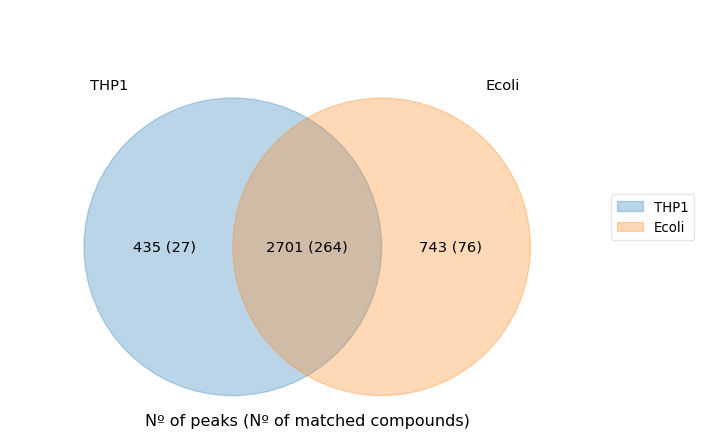

In [75]:
# Make a Venn diagram
labels = venn.get_labels([group_dfs[i].index for i in group_dfs], fill=['number'])
labels_ids = venn.get_labels([group_dfs_ids[i].index for i in group_dfs_ids], fill=['number'])

labels_all = {}
for i, j in labels.items():
    labels_all[i] = j + f' ({labels_ids[i]})'
    
c = [(c[0], c[1], c[2], 0.3) for c in colours]

if len(classes) == 2:
    fig, ax = venn.venn2(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 2 Classes
    plt.text(0.5,0, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 3:
    fig, ax = venn.venn3(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 3 Classes
    plt.text(0.5,-0.05, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 4:
    fig, ax = venn.venn4(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 4 Classes
    plt.text(0.5,0.05, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 5:
    fig, ax = venn.venn5(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 5 Classes
    plt.text(0.5,0, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 6:
    fig, ax = venn.venn6(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 6 Classes
    plt.text(0.5,0.2, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center') 
else:
    print(f'Venn Diagram can currently only be made with 2 to 6 different classes. You currently have {len(classes)} classes.')

# Step 6: Perform Multivariate Statistical Analysis

Multivariate statistical analysis is paramount to make sense out of complex metabolomics data. It comprises a wide range tecniques that capture different types of structure in the data.

Broadly, multivariate statistical analysis algorithms can be grouped in two categories:

- **Unsupervised Analysis:** When the algorithms are 'blind' to existence of pre-determined classes in the data. Unsupervised MSA techniques include Principal Component Analysis (PCA) and Hierarchical Clustering Analysis (HCA), both of which are shown here. These tecniques are most useful to determine if there are differences between the classes, as you will see samples of the same class clustering together (clearly separate from the rest) in that casa, but they are not very good at telling you which specific features (in this case, metabolites) are responsible for these differences.
- **Supervised Analysis:** When the algorithms 'known' before that there are classes in the data. Supervised MSA techniques can also usually be classed as Machine Learning models, and as such a form of Artificial Intelligence (AI). Examples include Random Forest Models (RFs), whoch we show here, but also Partial Least Squares Discriminant Analysis (PLSDA) and Gradient Boosting. These tecniques will 'force' separation, and as such are inadequate to determine whether or not the classes are different. However, once that difference has been established, supervised techniques perform much better at finding which features are responsible.

In [76]:
def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot confidence ellipses of a class' samples based on their projection in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        lbl_text = lbl.get_text()
        #print(type(list(label_colors)[0]))
        if type(list(label_colors)[0]) == np.float64:
            lbl_text = float(lbl_text)
        #print(type(lbl_text))   
        col = label_colors[lbl_text]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)

    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

### Principal Component Analysis (PCA) - Unsupervised

C:\Users\mtrig\anaconda3\lib\site-packages\matplotlib\patches.py:1470: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
C:\Users\mtrig\anaconda3\lib\site-packages\matplotlib\patches.py:1471: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))


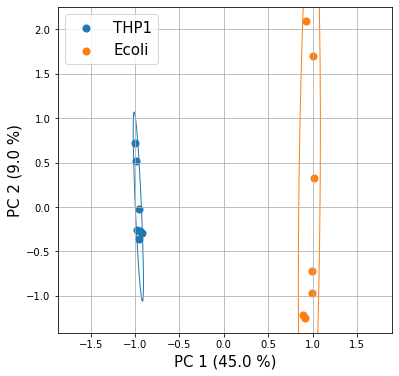

In [77]:
f, ax = plt.subplots(1, 1, figsize=(6,6)) # Change the size of the figure

principaldf, var, loadings = mda.compute_df_with_PCs_VE_loadings(treated_data, 
                                       n_components=2, # Select number of components to calculate
                                       whiten=True, labels=target, return_var_ratios_and_loadings=True)

# Plot PCA
ax.axis('equal')
lcolors = label_colours

plot_PCA(principaldf, lcolors, 
         components=(1,2), # Select components to see
         title='', # Select title of plot
         ax=ax)

# Remove ellipses by putting a # before the next line
plot_ellipses_PCA(principaldf, 
                  lcolors, 
                  components=(1,2), # Select components to see
                  ax=ax, 
                  q=0.95) # Confidence ellipse with 95% (q) confidence

ax.set_xlabel(f'PC 1 ({var[0] * 100:.1f} %)', size=15) # Set the size of labels
ax.set_ylabel(f'PC 2 ({var[1] * 100:.1f} %)', size=15) # Set the size of labels

plt.legend(fontsize=15) # Set the size of labels
plt.grid() # If you want a grid or not
plt.show()
#f.savefig('Name_PCAplot.png', dpi=400) # Save the figure

### Hierarchical Clustering Analysis (HCA) - Unsupervised

In [78]:
metric = 'euclidean' # Select distance metric
method = 'ward' # Select linkage method

distances = dist.pdist(treated_data, metric=metric)
Z = hier.linkage(distances, method=method)

hca_res = {'Z': Z, 'distances': distances}

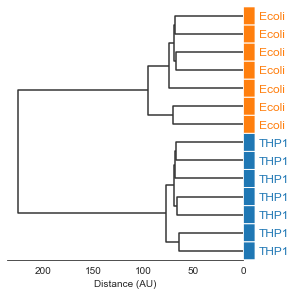

In [79]:
# Plot HCA
with sns.axes_style("white"):
    f, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True) # Set Figure Size
    plot_dendogram(hca_res['Z'], 
                   target, ax=ax,
                   label_colors=label_colours,
                   title='', # Select title
                   color_threshold=0) # Select a distance threshold from where different sets of lines are coloured

    plt.show()
    #f.savefig('Name_HCAplot.png', dpi=400) # Save the figure

### Random Forest models (RFs) - Supervised

A Random Forest (RF) is a collection of decision trees trained from different (randomly selected) subsections of the data. When used as classifiers, each decision tree will, by looking at whatever features it 'chooses', make a decision regarding the class to which each sample belongs. The end result of the classification will be decided by a vote between all trees.

To train it, we must first optimise the number of trees.

In [80]:
# Select a random seed (number between the ()) if you don't want the results to change every time you run the code
np.random.seed()

# See maximum number of trees to search
top_tree_in_grid=300

# Vector with values for the parameter n_estimators
# Models will be built from 10 to 300 trees in 5 tree intervals
values = {'n_estimators': range(10,top_tree_in_grid,5)}
    
rf = skensemble.RandomForestClassifier(n_estimators=200)
    
clf = GridSearchCV(rf, values, cv=2, n_jobs=-1) # Change cv to change cross-validation

print('Fitting RFs...', end=' ')

RF_optim = {'Treated':{}, 'BinSim':{}}
clf.fit(treated_data, target) # Fitting the data to RF models with all the different number of trees

# Storing results
RF_optim['Treated']['scores'] = list(clf.cv_results_['mean_test_score'])
RF_optim['Treated']['n_trees'] = list(clf.cv_results_['param_n_estimators'])

# BinSim turn
clf.fit(bin_data, target) # Fitting the data to RF models with all the different number of trees

# Storing results
RF_optim['BinSim']['scores'] = list(clf.cv_results_['mean_test_score'])
RF_optim['BinSim']['n_trees'] = list(clf.cv_results_['param_n_estimators'])


print('Done!')

Fitting RFs... Done!


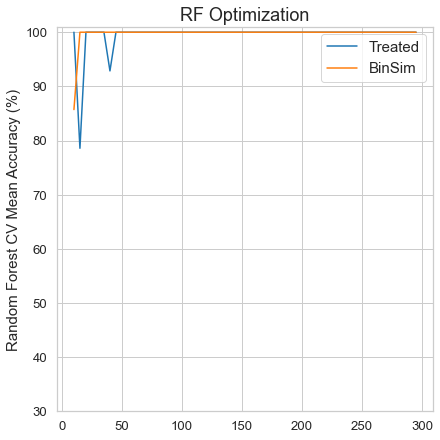

In [81]:
# Plotting the results and adjusting parameters of the plot
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(6,6), constrained_layout=True) # Set Figure Size

        c_map = sns.color_palette('tab10', 10)

        for treatment, c in zip(RF_optim.keys(), c_map):
            ax.plot(RF_optim[treatment]['n_trees'], [s*100 for s in RF_optim[treatment]['scores']], label=treatment, color=c)
        
        ax.set_ylabel('Random Forest CV Mean Accuracy (%)', fontsize=15) # Set the y_label and size
        ax.set_title('RF Optimization', fontsize=18) # Set the title and size
        ax.set_ylim([30,101]) # Set the limits on the y axis

        #f.suptitle('Optimization of the number of trees')
        ax.legend(fontsize=15) # Set the legend and size
        plt.show()

And now we fit the model...

In [82]:
# Choose a number for the seed for consistent results
np.random.seed()

n_trees=200 # Number of trees in the model

RF_results = mda.RF_model(treated_data, target, regres=False, # Data, labels and if it's a regression or classification
                return_cv=True, iter_num=5, # If you want cross validation results and number of iterations for it
                n_trees=n_trees, # Number of trees in the model
                cv=None, n_fold=3, # Choose a method of cross-validation (None is stratified cv) and the number of folds
                #metrics = ('neg_mean_squared_error', 'r2'), n_jobs=-1)
                metrics = ('accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted')) # Choose the performance metrics

Performance Analysis

In [83]:
rf_results_summary = pd.DataFrame(columns=['Value', 'Standard Deviation'])
for k,v in RF_results.items():
    if k != 'model' and k != 'imp_feat':
        rf_results_summary.loc[k] = np.mean(v), np.std(v)

print(rf_results_summary)

                    Value  Standard Deviation
accuracy              1.0                 0.0
f1_weighted           1.0                 0.0
precision_weighted    1.0                 0.0
recall_weighted       1.0                 0.0


If the model performed well, then the features of greater importance for classification should be of particular interest.

In [84]:
imp_feats_rf = meta_data.copy()
imp_feats_rf.insert(0,'Bucket label', imp_feats_rf.index)
imp_feats_rf.insert(1,'Gini Importance', '')
for n in range(len(RF_results['imp_feat'])):
    imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
imp_feats_rf = imp_feats_rf.sort_values(by='Gini Importance', ascending=False)
imp_feats_rf.index = range(1, len(imp_feats_rf)+1)

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
C:\Users\mtrig\AppData\Local\T

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
C:\Users\mtrig\AppData\Local\T

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
C:\Users\mtrig\AppData\Local\T

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_i

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
C:\Users\mtrig\AppData\Local\T

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
C:\Users\mtrig\AppData\Local\T

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/2204001288.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_i

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [85]:
imp_feats_rf.head(20) # Select number of features to see

,Bucket label,Gini Importance,m/z,Neutral Mass,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Has Match?
1,486.35322354801104 Da,0.002345,487.360500,486.353224,NaN,NaN,NaN,NaN,False
2,280.08811354801105 Da,0.00201,281.095390,280.088114,[HMDB0060842],[N-Despyridinyl rosiglitazone],[C13H16N2O3S],1,True
3,549.6007635480111 Da,0.00201,550.608040,549.600764,NaN,NaN,NaN,NaN,False
4,236.17522354801108 Da,0.00201,237.182500,236.175224,NaN,NaN,NaN,NaN,False
5,360.31974854801103 Da,0.002008,361.327025,360.319749,NaN,NaN,NaN,NaN,False
6,375.921133548011 Da,0.001682,376.928410,375.921134,NaN,NaN,NaN,NaN,False
7,377.91822354801104 Da,0.001678,378.925500,377.918224,NaN,NaN,NaN,NaN,False
8,220.01739354801106 Da,0.001678,221.024670,220.017394,NaN,NaN,NaN,NaN,False
9,351.165753548011 Da,0.001677,352.173030,351.165754,NaN,NaN,NaN,NaN,False
10,297.81094354801104 Da,0.001677,298.818220,297.810944,NaN,NaN,NaN,NaN,False


# Step 7: Perform Metabolic Pathway Mapping with KEGG

In [86]:
class_1_colour = 'red'
class_2_colour = 'blue'
both_colour = 'purple'

print('Present only in',classes[0]+':',class_1_colour)
print('Present only in',classes[1]+':',class_2_colour)
print('Present in both', class_1_colour, 'and', class_1_colour+':', both_colour)

Present only in THP1: red
Present only in Ecoli: blue
Present in both red and red: purple


In [87]:
if len(pd.unique(target)) == 2:

    kegg_data = annotated_data.copy()
    kegg_data = kegg_data.dropna(subset='Matched HMDB IDs')
    kegg_data = kegg_data[sample_cols+['Matched HMDB IDs']]
    kegg_data = kegg_data.explode('Matched HMDB IDs', ignore_index=True)
    kegg_data['Matched KEGG'] = np.nan
    for a in tqdm(kegg_data.index):
        kegg_hmdb_id = kegg_data['Matched HMDB IDs'][a]
        kegg_data['Matched KEGG'][a] = dbs['HMDB']['DB'].loc[kegg_hmdb_id]['kegg']
    kegg_data = kegg_data.dropna(subset='Matched KEGG')
    kegg_data['Colour'] = np.nan
    for k in kegg_data.index:
        k_df = kegg_data.loc[[k]]
        if k_df[groups[classes[0]]].isnull().values.all():
            kegg_data['Colour'][k] = class_2_colour
        elif k_df[groups[classes[1]]].isnull().values.all():
            kegg_data['Colour'][k] = class_1_colour
        else:
            kegg_data['Colour'][k] = both_colour
    kegg_data
else:
    print('Your data has more than two classes. Thus, KEGG colour mapping is not performed')

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/383719794.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if len(pd.unique(target)) == 2:
  0%|                                                                                         | 0/1006 [00:00<?, ?it/s]C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/383719794.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` inste

100%|████████████████████████████████████████████████████████████████████████████| 1006/1006 [00:00<00:00, 9694.49it/s]
C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/383719794.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  kegg_dat

In [88]:
SAVE_KEGG_COLOURS = True
if len(pd.unique(target)) == 2:
    kegg_colours = kegg_data[['Matched KEGG', 'Colour']]
    kegg_colours = kegg_colours.set_index('Matched KEGG')
    if SAVE_KEGG_COLOURS:
        kegg_colours_filename = filename.split('.')[0]+'_kegg_colours.csv'
        kegg_colours.to_csv(kegg_colours_filename, sep="\t")

C:\Users\mtrig\AppData\Local\Temp/ipykernel_32052/3771190344.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if len(pd.unique(target)) == 2:


## Step 8: Find Specific Compounds

This code will allow you to conveniently find specific compounds by their name, formula, m/z or neutral mass. The mass finders work even if you don't know the specific mass, as you can search only by the first few digits.

In [91]:
id_type = 'name' #pick 'formula', 'name', 'neutral mass' or 'm/z'
find_id = 'Proline'
if id_type == 'neutral mass':
    finder = processed_data.loc[processed_data.index.str.startswith(find_id)]
if id_type == 'm/z':
    finder = processed_data.loc[processed_data['m/z'].astype('str').str.startswith(find_id)]
if id_type == 'formula':
    index_list = []
    for col in meta_cols_formulas:
        temp_df = processed_data[[col]].dropna()
        for t in temp_df.index:
            if find_id in temp_df[col][t]:
                index_list.append(t)
    finder = processed_data.loc[processed_data.index.isin(index_list)]
if id_type == 'name':
    index_list = []
    for col in meta_cols_names:
        temp_df = processed_data[[col]].dropna()
        for t in temp_df.index:
            if find_id in temp_df[col][t]:
                index_list.append(t)
    finder = processed_data.loc[processed_data.index.isin(index_list)]
finder

,m/z,Neutral Mass,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Has Match?,THP1_1,THP1_2,THP1_3,...,THP1_5,THP1_6,THP1_7,Ecoli_1,Ecoli_2,Ecoli_3,Ecoli_4,Ecoli_5,Ecoli_6,Ecoli_7
Bucket label,,,,,,,,,,,,,,,,,,,,,


In [90]:
# Plot to see the intensities distribution (might become difficult to see with a lot of samples)
bar_plot_info = finder.replace({np.nan:0})
if len(bar_plot_info.index) == 1:
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    x = np.arange(len(bar_plot_info.columns[-len(sample_cols):]))
    for comps in range(len(bar_plot_info.index)):
        ax.barh(x, np.array(bar_plot_info.iloc[comps, -len(sample_cols):]), color=sample_colours)
        ax.set_ylabel('Normalized Intensity', fontsize=15)
        ax.set_title(find_id, fontsize=15)
else:
    fig, axs = plt.subplots(1,len(bar_plot_info.index), figsize=(16,6))

    x = np.arange(len(bar_plot_info.columns[-len(sample_cols):]))
    for (comps, ax) in zip(range(len(bar_plot_info.index)), axs.ravel()):
        ax.barh(x, np.array(bar_plot_info.iloc[comps, -len(sample_cols):]), color=sample_colours)
        ax.set_yticks([])
        #ax.tick_params(labelleft=False)
        ax.set_ylabel('Normalized Intensity', fontsize=13)
        ax.set_title(find_id)
    ax = axs[0]
ax.set_yticks(x)
ax.set_yticklabels(bar_plot_info.columns[-len(sample_cols):], fontsize=12)
plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1152x432 with 0 Axes>

In [ ]:
# Calculate average intensities
gfinder = finder.copy()
for g in groups:
    gfinder[g+' Average'] = gfinder[gfinder.columns.intersection(groups[g])].mean(axis=1)
    gfinder[g+' std'] = gfinder[gfinder.columns.intersection(groups[g])].std(axis=1)
gfinder

In [ ]:
avg_cols = [col for col in gfinder.columns if 'Average' in col]
std_cols = [col for col in gfinder.columns if 'std' in col]
group_colours = [label_colours[lbl] for lbl in classes]
bar_plot_info = gfinder.replace({np.nan:0})
if len(bar_plot_info.index) == 1:
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    x = np.arange(len(avg_cols))
    for comps in bar_plot_info.index:
        ax.bar(x, np.array(bar_plot_info.loc[comps, avg_cols]), color=group_colours, yerr=np.array(bar_plot_info.loc[comps, std_cols]), capsize=12)
        ax.set_ylabel('Normalized Intensity', fontsize=15)
        ax.set_title(find_id, fontsize=15)
        ax.set_xticks(x)
        ax.set_xticklabels(groups, fontsize=12)
else:
    fig, axs = plt.subplots(1,len(bar_plot_info.index), figsize=(16,6))

    x = np.arange(len(avg_cols))
    for (comps, ax) in zip(bar_plot_info.index, axs.ravel()):
        ax.bar(x, np.array(bar_plot_info.loc[comps, avg_cols]), color=group_colours, yerr=np.array(bar_plot_info.loc[comps, std_cols]), capsize=12)
        ax.set_yticks([])
        #ax.tick_params(labelleft=False)
        ax.set_ylabel('Normalized Intensity', fontsize=13)
        ax.set_title(find_id)
        ax.set_xticks(x)
        ax.set_xticklabels(groups)
    ax = axs[0]
plt.show()

In [ ]:
if len(finder.index) == 1:
    its_list = []
    for g in groups:
        its = finder[finder.columns.intersection(groups[g])].T.reset_index(drop= True)
        its_list.append(its)
    its_df = pd.concat(its_list, axis=1)
    its_df = its_df.set_axis(groups, axis=1)
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    box1= ax.boxplot(its_df, labels=its_df.columns, patch_artist=True, medianprops=dict(color='black'))
    for patch, color, lbl in zip(box1['boxes'], colours, its_df.columns):
        patch.set_facecolor(color)
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_title(find_id, fontsize=25)
    plt.show()
else:
    fig, axs = plt.subplots(1,len(finder.index), figsize=(16,6))
    for (comps, ax) in zip(finder.index, axs.ravel()):
        comps_df = finder.loc[[comps]]
        its_list = []
        for g in groups:
            its = comps_df[comps_df.columns.intersection(groups[g])].T.reset_index(drop= True)
            its_list.append(its)
        its_df = pd.concat(its_list, axis=1)
        its_df = its_df.set_axis(groups, axis=1)
        box1= ax.boxplot(its_df, labels=its_df.columns, patch_artist=True, medianprops=dict(color='black'))
        for patch, color, lbl in zip(box1['boxes'], colours, its_df.columns):
            patch.set_facecolor(color)
        ax.set_title(find_id, fontsize=15)
    ax = axs[0]
plt.show()

Metabolite statistics

In [ ]:
met_stats = mda.metabolite_statistics(finder, groups)
met_stats